In [1]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils.parallel import delayed
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.feature_selection import RFECV

In [2]:
import sys

!"{sys.executable}" -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 324 kB 995 kB/s eta 0:00:01
     |████████████████████████████████| 345 kB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 679 kB 47.5 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 84.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 77.5 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 74.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 74.2 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=aa7f3ddccde1bf7ecfd89c16e72c7148c950d561be19f8c5656f7e2c9a8f980f
  Stored in directory: /home/azureuser/.cache/pip/wheels/23/14/6e/4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
Successfully built htmlmin
ERROR: pmdarima 1.7.1 has requirement statsmodels<0.12,>=0.11, but you'll have statsmodels 0.13.5 which is incompatible.
ERROR: nbconvert 7.2.8 has requirement jinja2>=3.0, but you'll have jinja2 2.11.2 which is incompati

In [16]:
%%time
pandas_df = pd.read_csv('RFE_10_features.csv', index_col=0)

CPU times: user 8.01 s, sys: 885 ms, total: 8.89 s
Wall time: 14.6 s


In [8]:
pandas_df.dtypes

failure          int64
smart_1_raw      int64
smart_2_raw      int64
smart_3_raw      int64
smart_4_raw      int64
                 ...  
smart_245_raw    int64
smart_246_raw    int64
smart_247_raw    int64
smart_248_raw    int64
smart_254_raw    int64
Length: 76, dtype: object

In [3]:
from pathlib import Path

# Installed packages
import pandas as pd
from ipywidgets import widgets

# Our package
from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file

In [4]:
profile = ProfileReport(
    pandas_df, title="HDD", html={"style": {"full_width": True}}, sort=None
)

In [14]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [6]:
import seaborn as sns

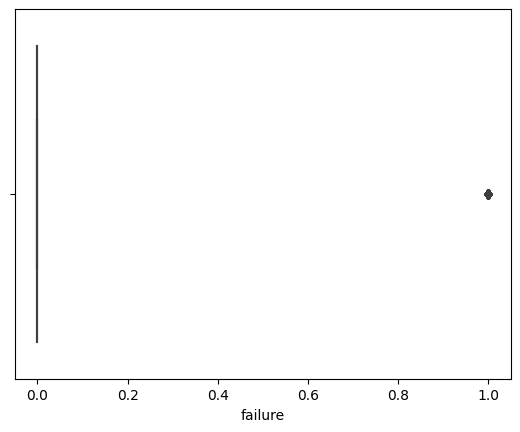

In [12]:

# Plot a boxplot of a single column
sns.boxplot(x='failure', data=pandas_df)


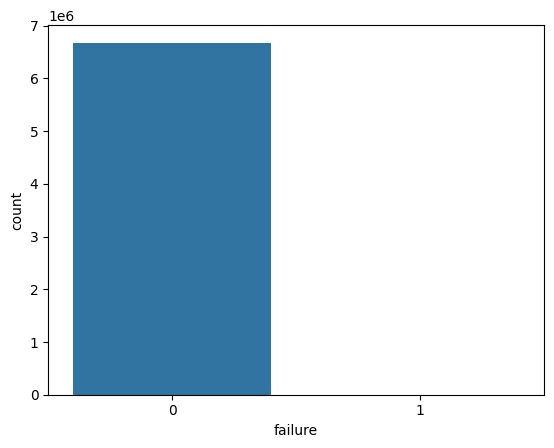

In [13]:
sns.countplot(x='failure', data=pandas_df)

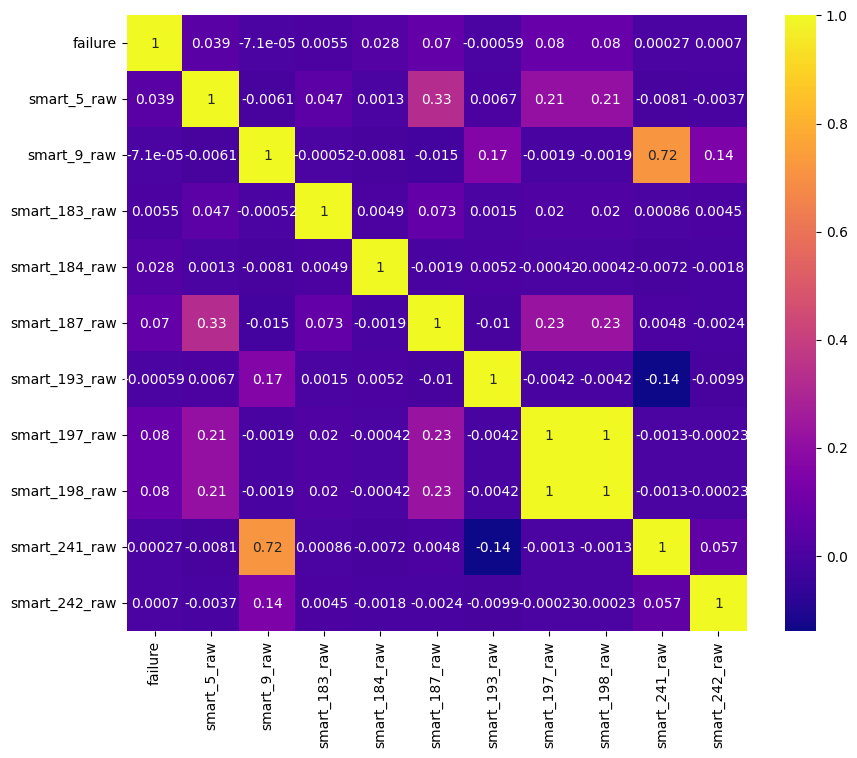

In [17]:
import matplotlib.pyplot as plt
corr = pandas_df.corr()

# Create a larger figure object
fig, ax = plt.subplots(figsize=(10, 8))

# Plot a heatmap of the correlation matrix on the larger figure object
sns.heatmap(corr, cmap='plasma', annot=True, ax=ax)

# Show the plot
plt.show()

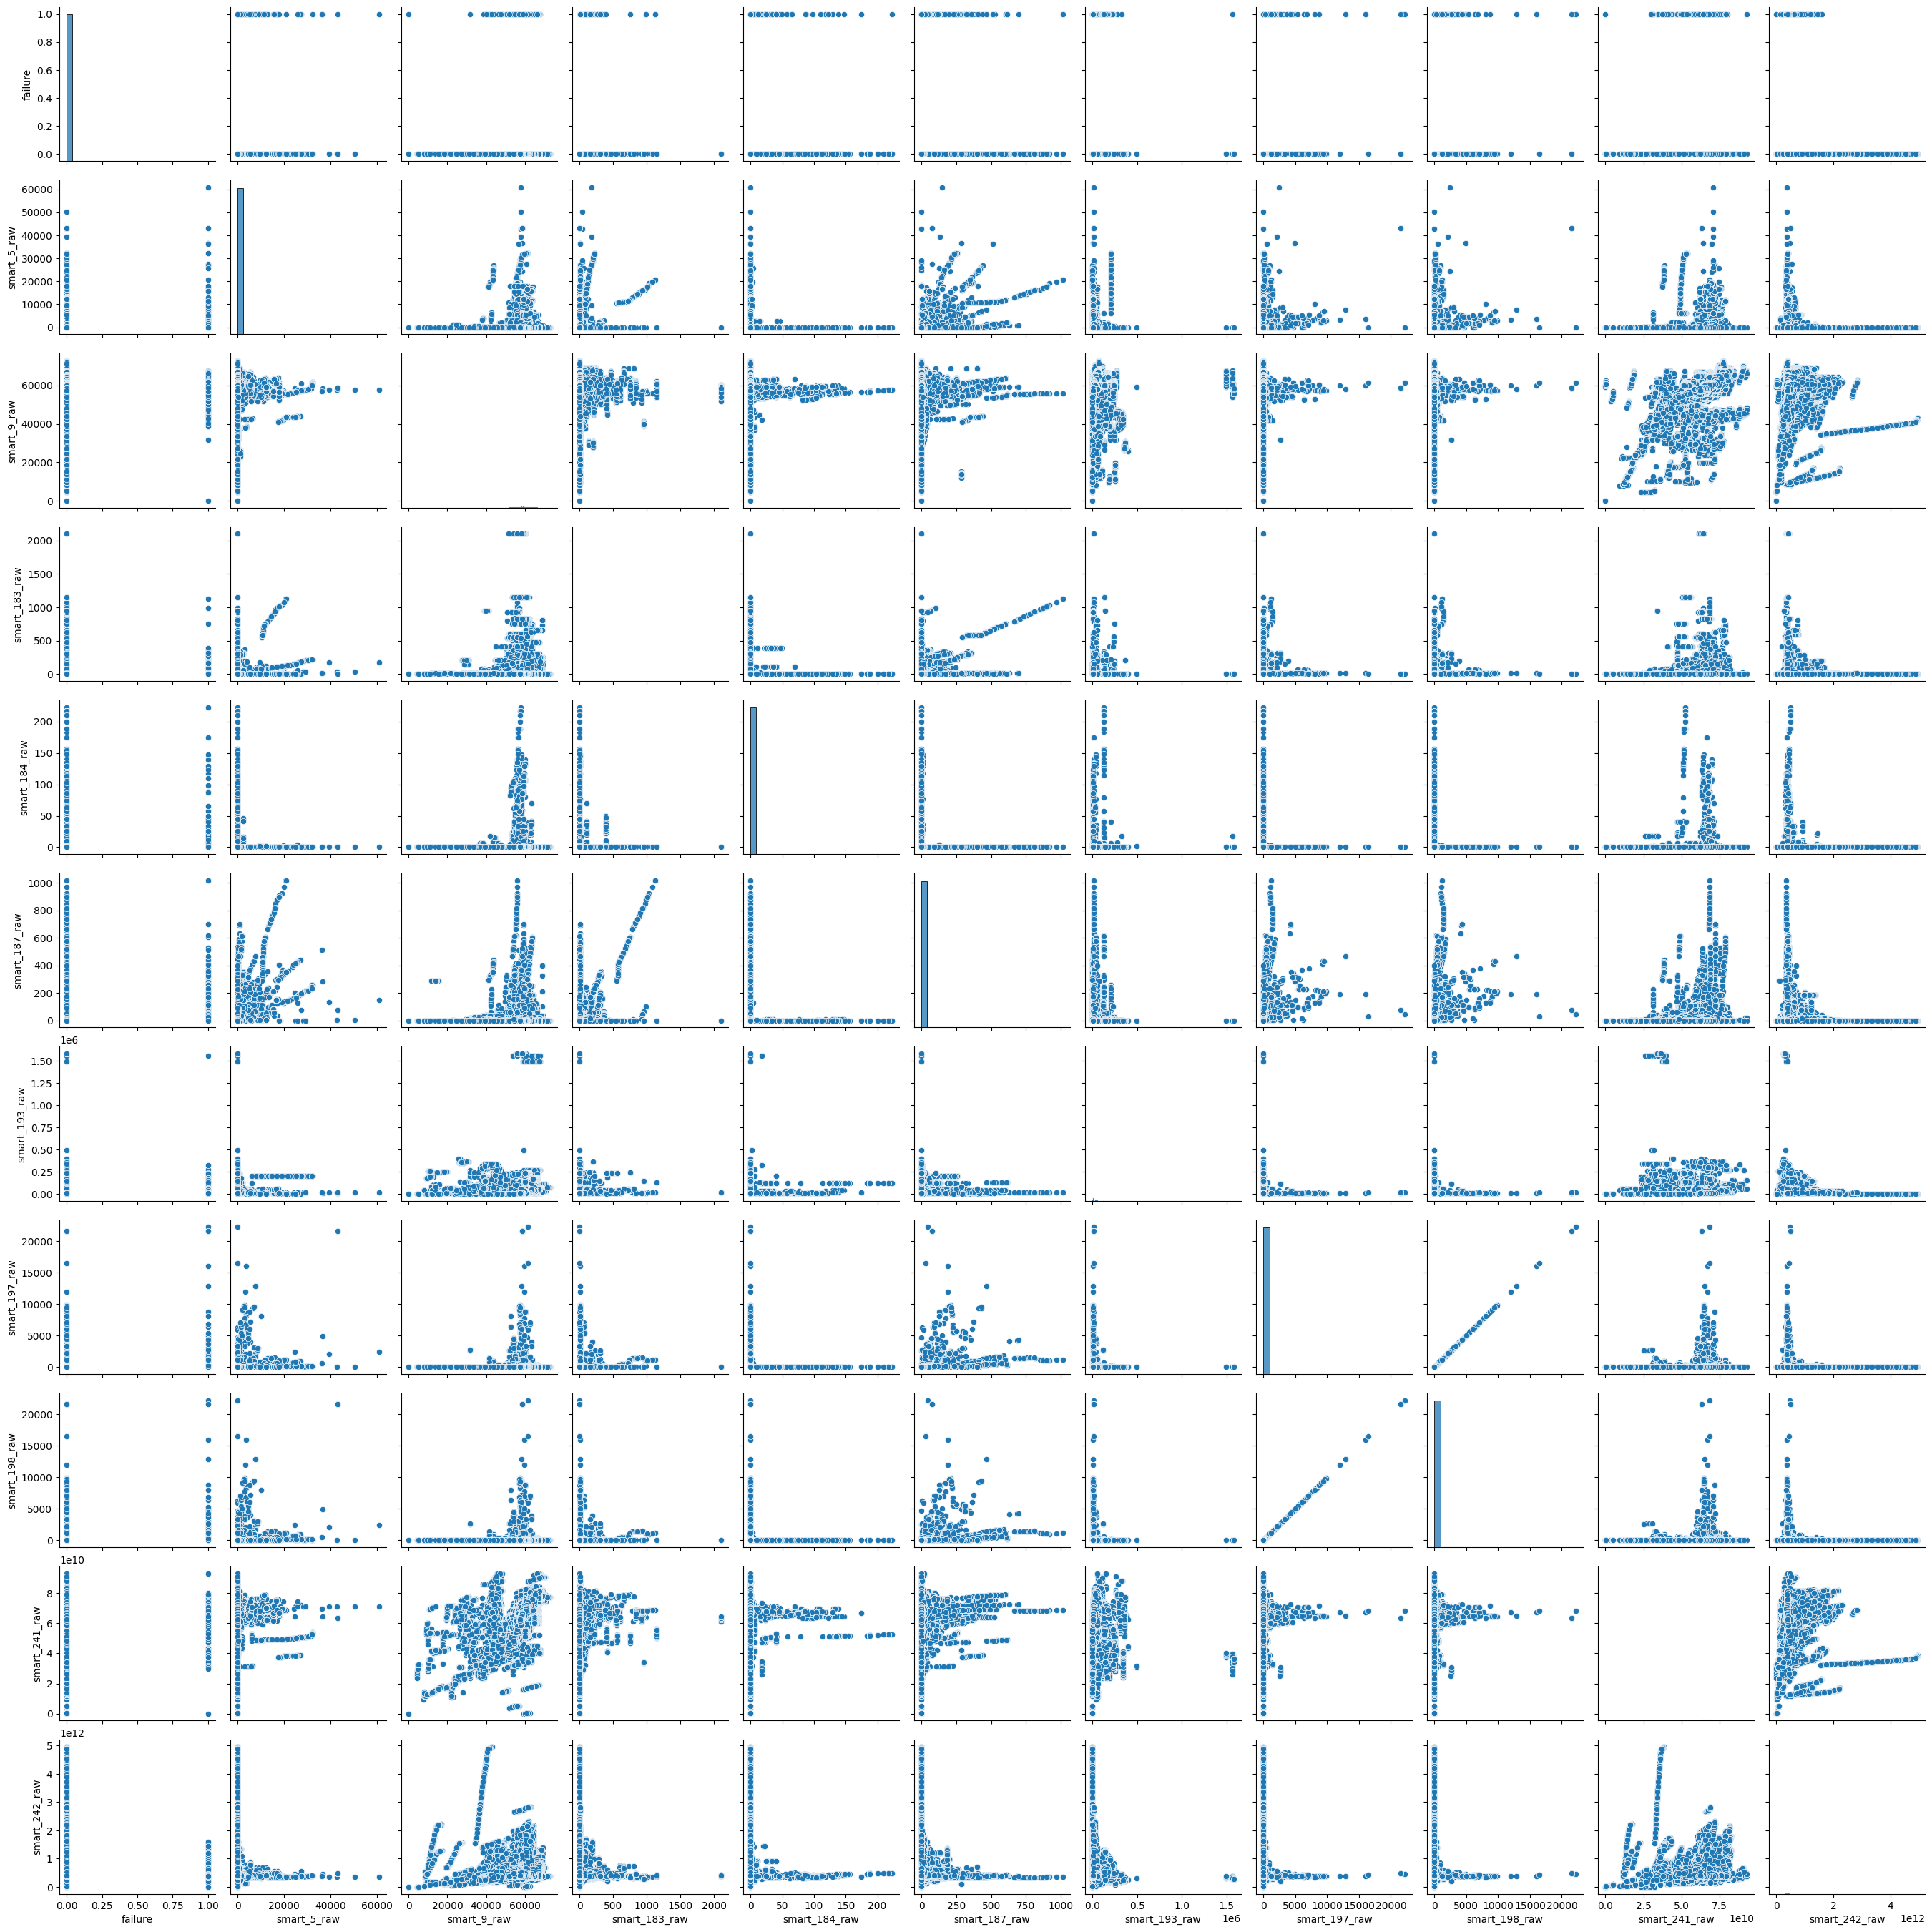

In [18]:
sns.pairplot(pandas_df)

In [3]:
pandas_df.duplicated().sum()

1699

In [4]:
# Count the number of 0s and 1s in the 'failure' column
num_failures = pandas_df['failure'].value_counts()

# Print the results
print('Number of 0s:', num_failures[0])
print('Number of 1s:', num_failures[1])

Number of 0s: 6680436
Number of 1s: 633


In [5]:
pandas_df = pandas_df.drop_duplicates()
pandas_df.duplicated().sum()

0

In [6]:
num_failures = pandas_df['failure'].value_counts()

# Print the results
print('Number of 0s:', num_failures[0])
print('Number of 1s:', num_failures[1])

Number of 0s: 6678738
Number of 1s: 632


In [7]:
X = pandas_df.drop('failure', axis=1).values
y = pandas_df['failure'].values

In [8]:
def fdr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fdr = tp / (tp + fn)
    return fdr

def far_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    far = fp / (fp + tn)
    return far
    


scoring = {'precision': 'precision','gmean': make_scorer(geometric_mean_score),'f1': 'f1' , 'recall':'recall', 'fdr': make_scorer(fdr_score), 'far': make_scorer(far_score)}

In [9]:
%%time
#RFE Feature Selection
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant',fill_value= 0)),
    ('scaler', MaxAbsScaler()),
    ('rfe', RFE(estimator = BalancedRandomForestClassifier(random_state=42, n_jobs=-1),n_features_to_select=10, step=5)),
    ('classifier', BalancedRandomForestClassifier(random_state=42, n_jobs=-1))
])

# evaluate the pipeline using cross-validation with G-mean
BRF_scores = cross_validate(pipeline, X, y, cv=5, scoring=scoring)
# print the mean G-mean score and standard deviation
print("Mean G-mean: {:.3f} (+/- {:.3f})".format(BRF_scores['test_gmean'].mean(), BRF_scores['test_gmean'].std()))
print("F1: ", BRF_scores['test_f1'].mean())
print("Precision: ", BRF_scores['test_precision'].mean())
print("FDR: ", BRF_scores['test_fdr'].mean())
print("FAR :", BRF_scores['test_far'].mean())
print("Recall: ", BRF_scores['test_recall'].mean())


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packa

Mean G-mean: 0.914 (+/- 0.015)
F1:  0.0034840831348660825
Precision:  0.0017455264388963338
FDR:  0.8766154230721159
FAR : 0.04760689727840191
Recall:  0.8766154230721159
CPU times: user 6min 39s, sys: 1min 25s, total: 8min 4s
Wall time: 54min 52s


In [9]:
#Feature Selection
# Create the estimator
from sklearn.feature_selection import RFE
estimator = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

# Create the RFE selector
rfe_selector = RFE(estimator, n_features_to_select=10, step=5)

# Fit the selector to the data
rfe_selector.fit(X, y)


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sk

RFE(estimator=BalancedRandomForestClassifier(n_jobs=-1, random_state=42),
    n_features_to_select=10, step=5)

In [13]:
for i in range(X.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe_selector.support_[i], rfe_selector.ranking_[i]))

Column: 0, Selected False, Rank: 2.000
Column: 1, Selected False, Rank: 5.000
Column: 2, Selected False, Rank: 5.000
Column: 3, Selected False, Rank: 2.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 2.000
Column: 6, Selected False, Rank: 5.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 5.000
Column: 9, Selected False, Rank: 4.000
Column: 10, Selected False, Rank: 2.000
Column: 11, Selected False, Rank: 6.000
Column: 12, Selected False, Rank: 4.000
Column: 13, Selected False, Rank: 6.000
Column: 14, Selected False, Rank: 6.000
Column: 15, Selected False, Rank: 6.000
Column: 16, Selected False, Rank: 6.000
Column: 17, Selected False, Rank: 8.000
Column: 18, Selected False, Rank: 7.000
Column: 19, Selected False, Rank: 7.000
Column: 20, Selected False, Rank: 7.000
Column: 21, Selected False, Rank: 11.000
Column: 22, Selected False, Rank: 11.000
Column: 23, Selected False, Rank: 11.000
Column: 24, Selected False, Rank: 11.000
Column: 

In [17]:
for i, col_name in enumerate(pandas_df.drop('failure', axis=1).columns):
    print(f"Column {i}: {col_name}")

Column 0: smart_1_raw
Column 1: smart_2_raw
Column 2: smart_3_raw
Column 3: smart_4_raw
Column 4: smart_5_raw
Column 5: smart_7_raw
Column 6: smart_8_raw
Column 7: smart_9_raw
Column 8: smart_10_raw
Column 9: smart_11_raw
Column 10: smart_12_raw
Column 11: smart_13_raw
Column 12: smart_16_raw
Column 13: smart_17_raw
Column 14: smart_18_raw
Column 15: smart_22_raw
Column 16: smart_23_raw
Column 17: smart_24_raw
Column 18: smart_165_raw
Column 19: smart_166_raw
Column 20: smart_167_raw
Column 21: smart_168_raw
Column 22: smart_169_raw
Column 23: smart_170_raw
Column 24: smart_171_raw
Column 25: smart_172_raw
Column 26: smart_173_raw
Column 27: smart_174_raw
Column 28: smart_177_raw
Column 29: smart_179_raw
Column 30: smart_180_raw
Column 31: smart_181_raw
Column 32: smart_182_raw
Column 33: smart_183_raw
Column 34: smart_184_raw
Column 35: smart_187_raw
Column 36: smart_188_raw
Column 37: smart_189_raw
Column 38: smart_190_raw
Column 39: smart_191_raw
Column 40: smart_192_raw
Column 41: 

In [18]:
for i in range(X.shape[1]):
    if rfe_selector.support_[i]:
        print('Selected Column: %s, Rank: %.3f' % (pandas_df.drop('failure',axis=1).columns[i], rfe_selector.ranking_[i]))

Selected Column: smart_5_raw, Rank: 1.000
Selected Column: smart_9_raw, Rank: 1.000
Selected Column: smart_183_raw, Rank: 1.000
Selected Column: smart_184_raw, Rank: 1.000
Selected Column: smart_187_raw, Rank: 1.000
Selected Column: smart_193_raw, Rank: 1.000
Selected Column: smart_197_raw, Rank: 1.000
Selected Column: smart_198_raw, Rank: 1.000
Selected Column: smart_241_raw, Rank: 1.000
Selected Column: smart_242_raw, Rank: 1.000


In [19]:
selected_columns = ['failure','smart_5_raw', 'smart_9_raw', 'smart_183_raw', 'smart_184_raw', 
                    'smart_187_raw', 'smart_193_raw', 'smart_197_raw', 'smart_198_raw', 
                    'smart_241_raw', 'smart_242_raw']
df_selected = pandas_df.loc[:,selected_columns]
df_selected.head()


failure  smart_5_raw  smart_9_raw  smart_183_raw  smart_184_raw  \
0        0            0        56776              0              0   
1        0            0        58746              0              0   
2        0            0        53468              0              0   
3        0            0        53804              0              0   
4        0            0        60198              0              0   

   smart_187_raw  smart_193_raw  smart_197_raw  smart_198_raw  smart_241_raw  \
0              0           9374              0              0    69477598000   
1              0          49760              0              0    68899470440   
2              0          53576              0              0    56870347352   
3              0           7493              0              0    61124976952   
4              0          38087              0              0    72258413320   

   smart_242_raw  
0   572668460964  
1   441746036126  
2   328670471836  
3   510085438777  
4   371504760918

In [71]:
df_selected.to_csv('RFE_10_features.csv')